# Markov Chain Monte Carlo (MCMC) Introduction
MCMC is used to sample from complex probability distributions. Sampling from a simple distribution like the uniform $U(0,1)$ is easy enough using pseudorandom number generators, but things get harder for more complex distributions.

For more complex distributions, such as the normal, more complex, but still relatively simple, approaches like the inverse transform can be used to perform samplgin , provided the CDF can be calculated in close form.

For an even more complex distribution, $p(x)$, the CDF cannot be calculated, and a more sophisticated algorithm must be used. To obtain sample $x$ from $p(x)$, Monte Carlo is used.

## Metropolis-Hastings (MH)
The *Metropolis-Hastings* (MH) algorithm is the populat MCMC method. It starts with a point $x$ on the target distribution $p(x)$, whose form is known. A proposal value $x^*$ is obtained by sampling from the proposal distribution $q(x^*|x), which depends on the current value $x$. The proposal $x^*$ is "accepted" as a sample with probability:

$$A(x,x^*) = min \left\{1, \frac{p(x^*)q(x|x^*)}{p(x)q(x^*|x)}\right\}$$

If the proposal is rejected, then the current value $x$ is used as the sample again. The final list of values, from $x$'s and $x^*$'s, will be distributed according to $p(x)$.

The pseudo-code is shown below:

1. Initialize $x_0$
2. For $i = 0$ to $N-1$
    * Sample $x^*$ ~ $q(x^*|x_i)$
    * Sample $u$ ~ $U(0,1)$
    * **If**: $u < A(x_i,x^*) = min \left\{1, \frac{p(x^*)q(x_i|x^*)}{p(x_i)q(x^*|x_i)}\right\}$  
    $x_{i+1} = x^*$  
    **else**:  
    $x_{i+1} = x_i$

This algorithm results in $N$ samples from the target distribution $p(x)$. The values jumps around, guided by the proposal distribution and the acceptance probability, and the sample eventually converge to the desired distribution.

Note that the proposal distribution depends only on the current state $x$, and none before. Since the probability of the next step only depends on the current state, the sequence forms a Markov Chain.

### Technical Note
Without getting too deep into the theory, MCMC aims to find a Markov Chain whose stationary distribution is the distribution we need to sample from. This requires care selection of the proposal distribution $q(x)$, but detailed discusssion is beyond our scoep, and we'll show an example instead.

## Example
We will use MH to sample from the distribution $p(x) = 0.3e^{-0.2x^2}+0.7e^{-0.2(x-10)^2}$. This is plotted below to give a sense of its shape:

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [38]:
# define the pdf
p = lambda x: 0.3*np.exp(-0.2*x**2)+0.7*np.exp(-0.2*(x-10)**2)

Text(0,0.5,'p(x)')

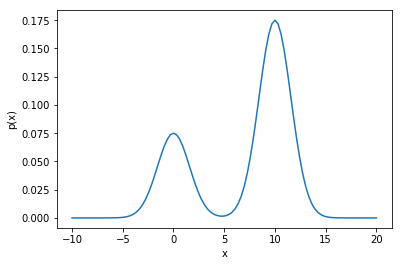

In [39]:
# plot the target distribution
x_1 = np.linspace(-10,20,100)

# normalization constant, calculated using Wolfram Alpha
Z = 4

plt.plot(x_1,p(x_1)/4)
plt.xlabel('x')
plt.ylabel('p(x)')

Now that we have a sense of the target distribution, let's look at the proposal distribution $w(x)$. In this example we'll use a Gaussian: $q(x^*|x) = N(x^*,\sigma^2)$ where $\sigma = 10$.

In [40]:
# proposal distribution pdf
sigma = 10
q = lambda x, x_s: (1/(2*np.pi*sigma**2)**0.5)*np.exp(-(x_s-x)**2/(2*sigma**2))

# sample from the proposal distribution
q_sample = lambda x: np.random.normal(loc=x, scale=sigma)

Now let's define the acceptance probability $A(x,x^*)$

In [41]:
# Acceptance probability
A = lambda x, x_s: min(1,((p(x_s)*q(x_s,x))/(p(x)*q(x,x_s))))

## Let's run the algorithm

In [42]:
# number of samples
N = 10000

# initialize the sample
x = np.zeros(N)

In [43]:
# time the simulation
t0 = time.time()

# run the MCMC algorithm
for i in range(N-1):
    
    # sample from uniform for the acceptance probability
    u = np.random.uniform(low=0, high=1)
    
    # sample from the proposal distribution
    x_s = q_sample(x[i])
    
    # accept the proposal with probability A
    if u < A(x[i], x_s):
        x[i+1] = x_s
    else:
        x[i+1] = x[i]
        
    # print status updates    
    if (i % (N/10)) == 0:
        print("fraction done:,", float(i)/N)

fraction done:, 0.0
fraction done:, 0.1
fraction done:, 0.2
fraction done:, 0.3
fraction done:, 0.4
fraction done:, 0.5
fraction done:, 0.6
fraction done:, 0.7
fraction done:, 0.8
fraction done:, 0.9


time in seconds: 83.99115800857544


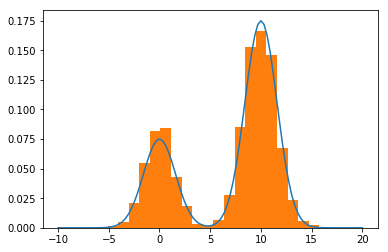

In [36]:
# Plot the resulting samples against the target distribution
plt.plot(x_1,p(x_1)/4)
weights = np.ones_like(x)/float(len(x))  # normalize the bins
plt.hist(x, weights=weights, bins=20)

print("time in seconds:", time.time()-t0)

As expected, the histogram of the samples approximates the target distribution. The states travel around the target distribution and both modes have been vistited and sampled from.

## References
http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf